# Pattern Mining

## Heart Failure Prediction Dataset

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
import mlxtend.frequent_patterns as pm
from mlxtend.preprocessing import TransactionEncoder

### Discretize Numeric Variables - Dummification

In [2]:
from sklearn.preprocessing import OneHotEncoder

def dummify(df, cols_to_dummify):
    one_hot_encoder = OneHotEncoder(sparse=False)

    for var in cols_to_dummify:
        one_hot_encoder.fit(data[var].values.reshape(-1, 1))
        feature_names = one_hot_encoder.get_feature_names([var])
        transformed_data = one_hot_encoder.transform(data[var].values.reshape(-1, 1))
        df = pd.concat((df, pd.DataFrame(transformed_data, columns=feature_names)), 1)
        df.pop(var)
    return df

In [30]:
data: pd.DataFrame = pd.read_csv('../datasets/heart_failure_clinical_records_dataset.csv')

b_vars = ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking", "DEATH_EVENT"] 
numeric_vars = data.select_dtypes(include='number').columns
for to_drop in b_vars:
    numeric_vars = numeric_vars.drop(to_drop)
    
dummyData = dummify(data, numeric_vars)

print(data.shape)
print(dummyData.shape)

dummyData.head()

(299, 13)
(299, 669)


,anaemia,diabetes,high_blood_pressure,sex,smoking,DEATH_EVENT,age_40.0,age_41.0,age_42.0,age_43.0,...,time_247,time_250,time_256,time_257,time_258,time_270,time_271,time_278,time_280,time_285
0,0,0,1,1,0,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,1,0,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,1,1,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,0,1,0,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1,0,0,0,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Patterns

In [31]:
MIN_SUP: float = 0.001
var_min_sup =[0.2, 0.1] + [i*MIN_SUP for i  in range(100, 0, -10)]

te = TransactionEncoder()
te_ary = te.fit(dummyData).transform(dummyData)
data = pd.DataFrame(te_ary, columns=te.columns_)

patterns: pd.DataFrame = pm.apriori(data, min_support=MIN_SUP, use_colnames=True, verbose=True)
print(len(patterns),'patterns')
nr_patterns = []
for sup in var_min_sup:
    pat = patterns[patterns['support']>=sup]
    nr_patterns.append(len(pat))

plt.figure(figsize=(6, 4))
ds.plot_line(var_min_sup, nr_patterns, title='Nr Patterns x Support', xlabel='support', ylabel='Nr Patterns')
plt.show()

IndexError: index 299 is out of bounds for axis 0 with size 299

### Association Rules

In [18]:
def plot_top_rules(rules: pd.DataFrame, metric: str, per_metric: str) -> None:
    _, ax = plt.subplots(figsize=(6, 3))
    ax.grid(False)
    ax.set_axis_off()
    ax.set_title(f'TOP 10 per Min {per_metric} - {metric}', fontweight="bold")
    text = ''
    cols = ['antecedents', 'consequents']
    rules[cols] = rules[cols].applymap(lambda x: tuple(x))
    for i in range(len(rules)):
        rule = rules.iloc[i]
        text += f"{rule['antecedents']} ==> {rule['consequents']}"
        text += f"(s: {rule['support']:.2f}, c: {rule['confidence']:.2f}, lift: {rule['lift']:.2f})\n"
    ax.text(0, 0, text)
    plt.show()

def analyse_per_metric(rules: pd.DataFrame, metric: str, metric_values: list) -> list:
    print(f'Analyse per {metric}...')
    conf = {'avg': [], 'top25%': [], 'top10': []}
    lift = {'avg': [], 'top25%': [], 'top10': []}
    top_conf = []
    top_lift = []
    nr_rules = []
    for m in metric_values:
        rs = rules[rules[metric] >= m]
        nr_rules.append(len(rs))
        conf['avg'].append(rs['confidence'].mean(axis=0))
        lift['avg'].append(rs['lift'].mean(axis=0))

        top_conf = rs.nlargest(int(0.25*len(rs)), 'confidence')
        conf['top25%'].append(top_conf['confidence'].mean(axis=0))
        top_lift = rs.nlargest(int(0.25*len(rs)), 'lift')
        lift['top25%'].append(top_lift['lift'].mean(axis=0))

        top_conf = rs.nlargest(10, 'confidence')
        conf['top10'].append(top_conf['confidence'].mean(axis=0))
        top_lift = rs.nlargest(10, 'lift')
        lift['top10'].append(top_lift['lift'].mean(axis=0))

    _, axs = plt.subplots(1, 2, figsize=(10, 5), squeeze=False)
    ds.multiple_line_chart(metric_values, conf, ax=axs[0, 0], title=f'Avg Confidence x {metric}',
                           xlabel=metric, ylabel='Avg confidence')
    ds.multiple_line_chart(metric_values, lift, ax=axs[0, 1], title=f'Avg Lift x {metric}',
                           xlabel=metric, ylabel='Avg lift')
    plt.show()

    plot_top_rules(top_conf, 'confidence', metric)
    plot_top_rules(top_lift, 'lift', metric)

    return nr_rules

### Quality Evaluation per Confidence

In [19]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='confidence', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 2976813 rules


Analyse per confidence...


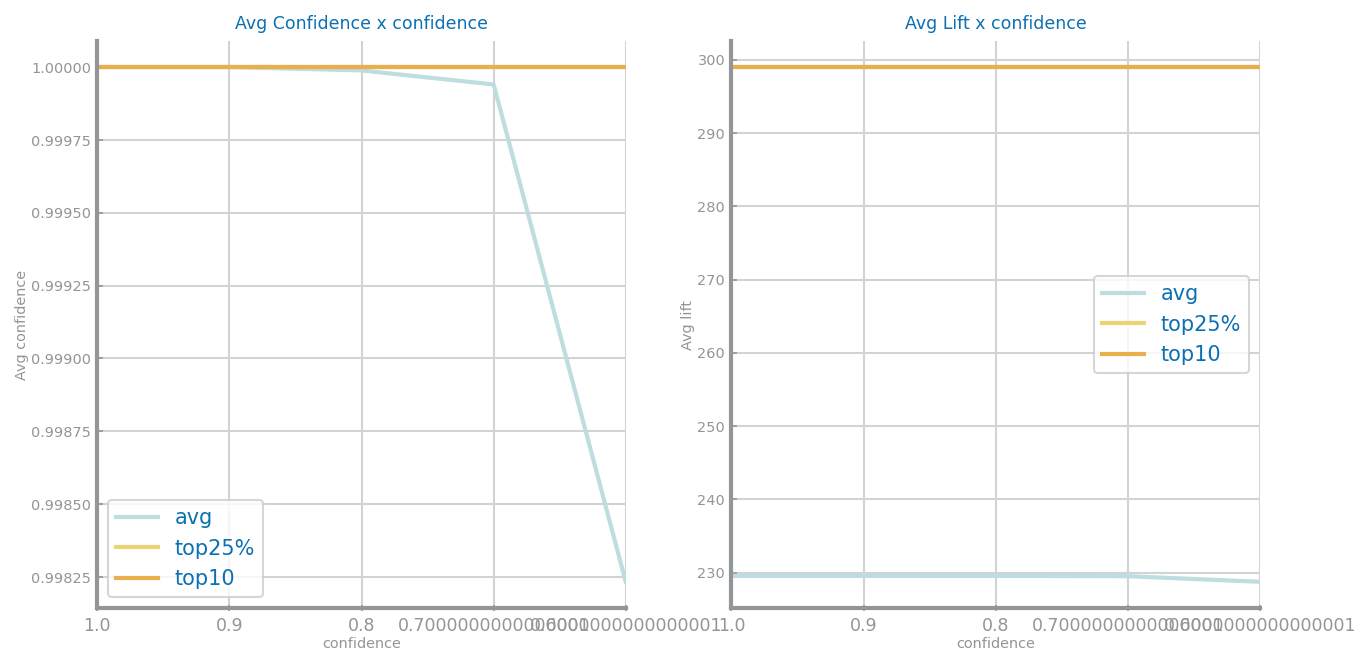

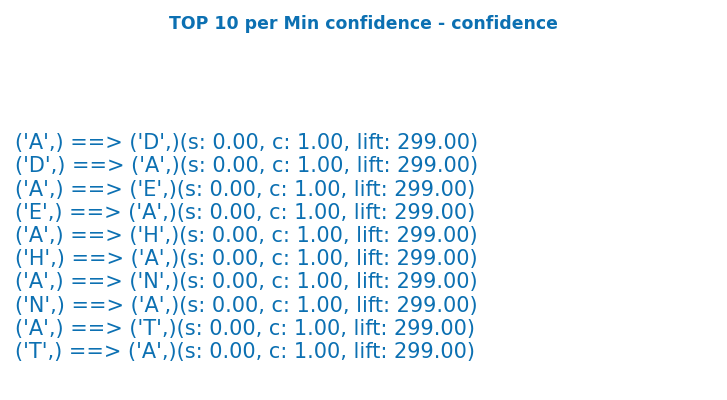

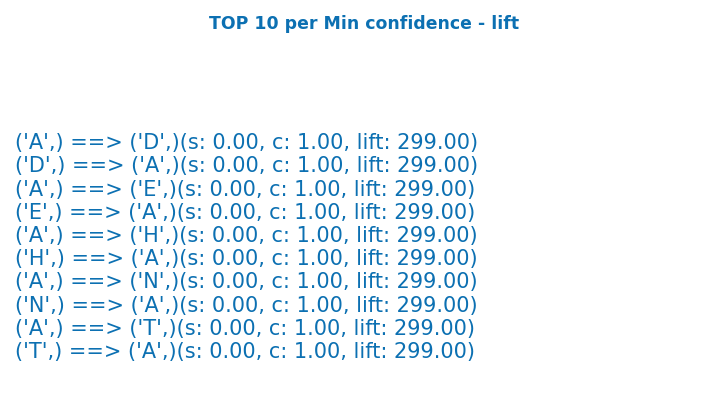

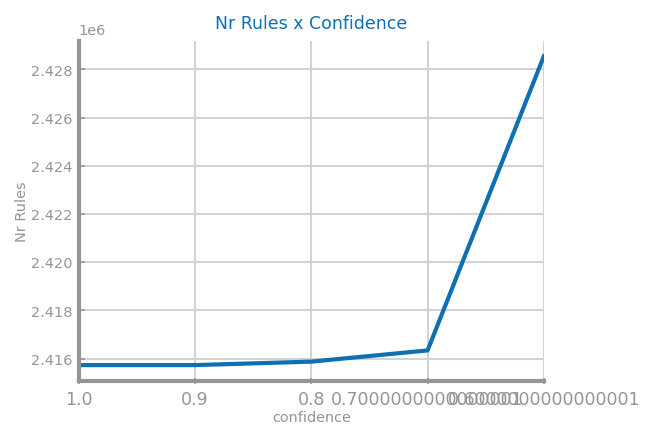

In [20]:
var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
nr_rules_cf = analyse_per_metric(rules, 'confidence', var_min_conf)
ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x Confidence', xlabel='confidence', ylabel='Nr Rules', percentage=False)

### Quality Evaluation per Support

In [21]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='support', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 0 rules


In [22]:
#var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
#nr_rules_cf = analyse_per_metric(rules, 'support', var_min_conf)
#ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x Support', xlabel='support', ylabel='Nr Rules', percentage=False)

### Quality Evaluation per Lift

In [23]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='lift', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 3479156 rules


Analyse per lift...


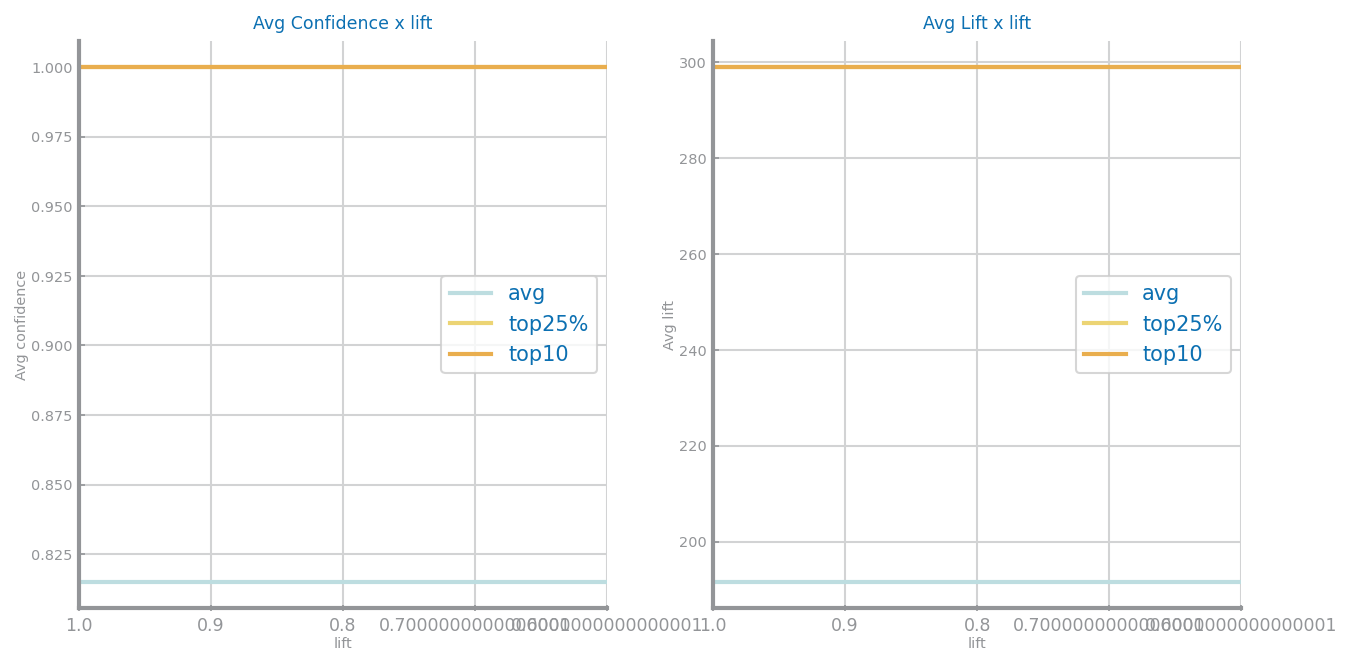

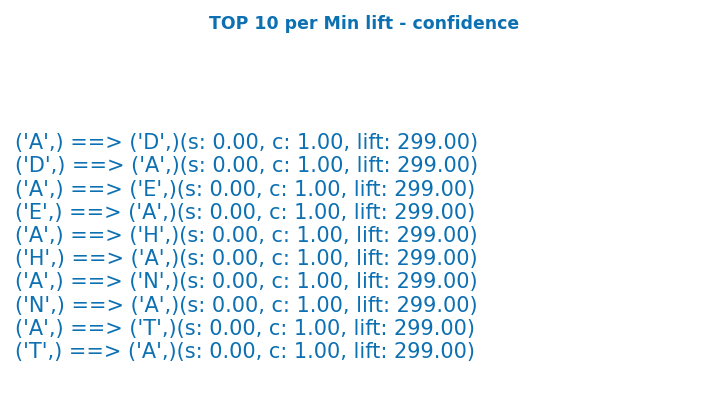

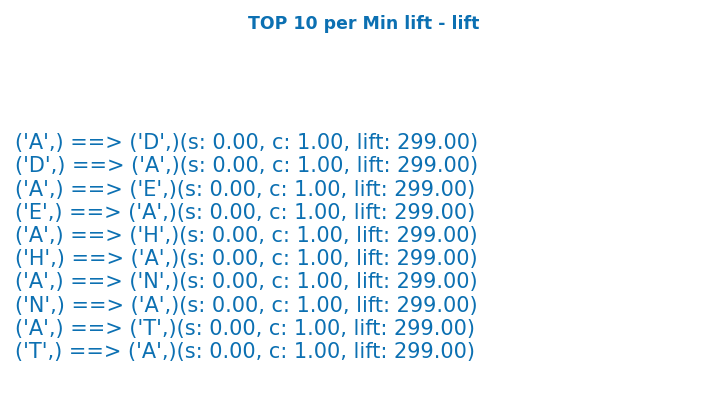

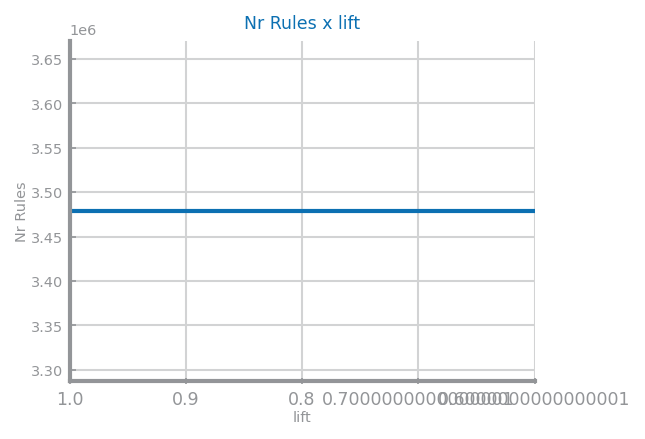

In [24]:
var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
nr_rules_cf = analyse_per_metric(rules, 'lift', var_min_conf)
ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x lift', xlabel='lift', ylabel='Nr Rules', percentage=False)

### Quality Evaluation per Leverage

In [25]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='leverage', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 0 rules


In [26]:
#var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
#nr_rules_cf = analyse_per_metric(rules, 'leverage', var_min_conf)
#ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x leverage', xlabel='leverage', ylabel='Nr Rules', percentage=False)

### Quality Evaluation per Conviction

In [27]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='conviction', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 3479156 rules


Analyse per conviction...


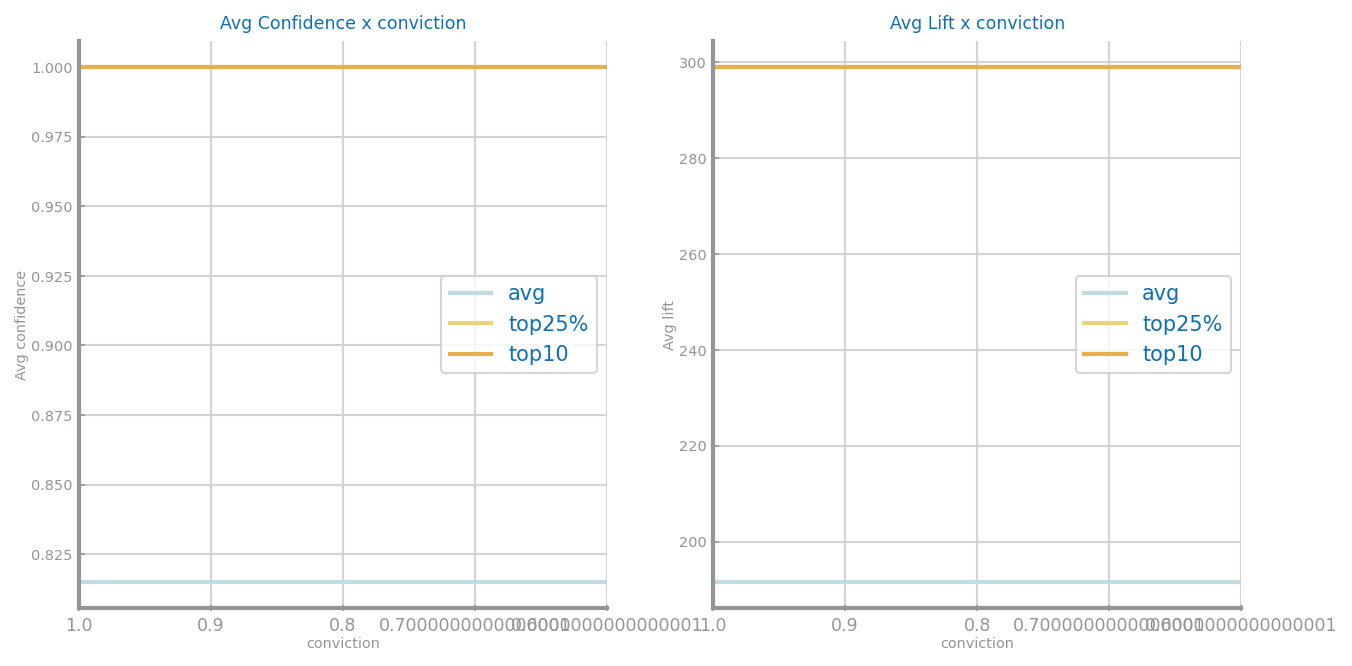

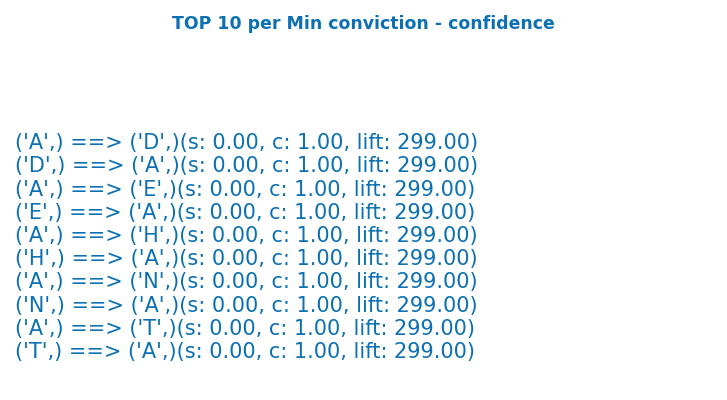

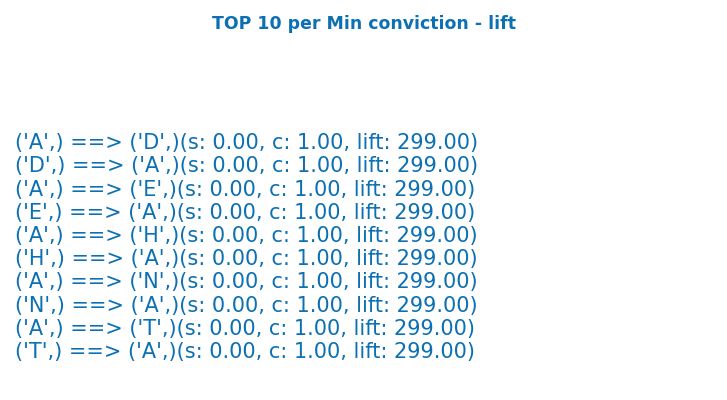

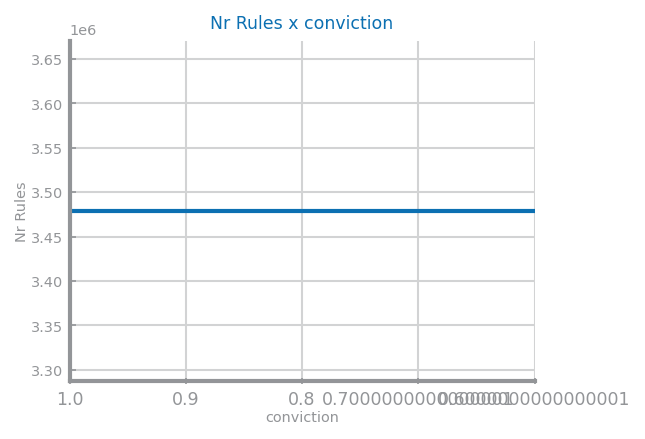

In [28]:
var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
nr_rules_cf = analyse_per_metric(rules, 'conviction', var_min_conf)
ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x conviction', xlabel='conviction', ylabel='Nr Rules', percentage=False)

<br />
<br />

### Discretize Numeric Variables - Number of bins = Minimum Number of Unique Variables

In [33]:
data: pd.DataFrame = pd.read_csv('../datasets/heart_failure_clinical_records_dataset.csv')

numeric_vars = data.select_dtypes(include='number').columns

min_num_unique = 1e10
for n in range(len(numeric_vars)):
    num_unique = len(list(set(data[numeric_vars[n]].values)))
    if(num_unique > 2): 
        if(min_num_unique > num_unique):
            min_num_unique = num_unique
            
for n in range(len(numeric_vars)):
    num_unique = len(list(set(data[numeric_vars[n]].values)))
    if(num_unique > 2): 
        data[numeric_vars[n]] = pd.cut(data[numeric_vars[n]], min_num_unique, labels = list(range(0, min_num_unique)))
        
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,10,0,1,0,1,1,4,2,8,1,0,0,1
1,4,0,16,0,6,0,4,1,11,1,0,0,1
2,7,0,0,0,1,0,2,1,7,1,1,0,1
3,3,1,0,0,1,0,3,2,11,1,0,0,1
4,7,1,0,1,1,0,6,4,1,0,0,0,1


### Patterns

Processing 14 combinations | Sampling itemset size 14320
19791 patterns


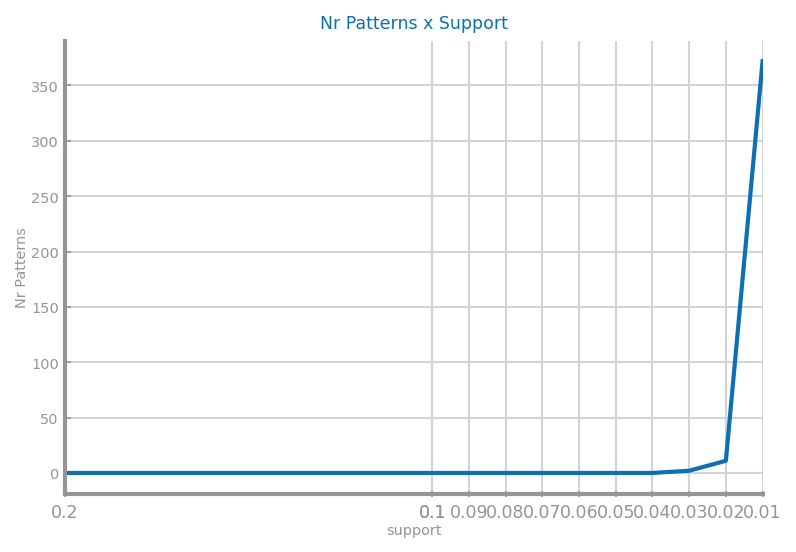

In [34]:
MIN_SUP: float = 0.001
var_min_sup =[0.2, 0.1] + [i*MIN_SUP for i  in range(100, 0, -10)]


te = TransactionEncoder()
te_ary = te.fit(data).transform(data)
data = pd.DataFrame(te_ary, columns=te.columns_)

patterns: pd.DataFrame = pm.apriori(data, min_support=MIN_SUP, use_colnames=True, verbose=True)
print(len(patterns),'patterns')
nr_patterns = []
for sup in var_min_sup:
    pat = patterns[patterns['support']>=sup]
    nr_patterns.append(len(pat))

plt.figure(figsize=(6, 4))
ds.plot_line(var_min_sup, nr_patterns, title='Nr Patterns x Support', xlabel='support', ylabel='Nr Patterns')
plt.show()

### Association Rules

In [35]:
def plot_top_rules(rules: pd.DataFrame, metric: str, per_metric: str) -> None:
    _, ax = plt.subplots(figsize=(6, 3))
    ax.grid(False)
    ax.set_axis_off()
    ax.set_title(f'TOP 10 per Min {per_metric} - {metric}', fontweight="bold")
    text = ''
    cols = ['antecedents', 'consequents']
    rules[cols] = rules[cols].applymap(lambda x: tuple(x))
    for i in range(len(rules)):
        rule = rules.iloc[i]
        text += f"{rule['antecedents']} ==> {rule['consequents']}"
        text += f"(s: {rule['support']:.2f}, c: {rule['confidence']:.2f}, lift: {rule['lift']:.2f})\n"
    ax.text(0, 0, text)
    plt.show()

def analyse_per_metric(rules: pd.DataFrame, metric: str, metric_values: list) -> list:
    print(f'Analyse per {metric}...')
    conf = {'avg': [], 'top25%': [], 'top10': []}
    lift = {'avg': [], 'top25%': [], 'top10': []}
    top_conf = []
    top_lift = []
    nr_rules = []
    for m in metric_values:
        rs = rules[rules[metric] >= m]
        nr_rules.append(len(rs))
        conf['avg'].append(rs['confidence'].mean(axis=0))
        lift['avg'].append(rs['lift'].mean(axis=0))

        top_conf = rs.nlargest(int(0.25*len(rs)), 'confidence')
        conf['top25%'].append(top_conf['confidence'].mean(axis=0))
        top_lift = rs.nlargest(int(0.25*len(rs)), 'lift')
        lift['top25%'].append(top_lift['lift'].mean(axis=0))

        top_conf = rs.nlargest(10, 'confidence')
        conf['top10'].append(top_conf['confidence'].mean(axis=0))
        top_lift = rs.nlargest(10, 'lift')
        lift['top10'].append(top_lift['lift'].mean(axis=0))

    _, axs = plt.subplots(1, 2, figsize=(10, 5), squeeze=False)
    ds.multiple_line_chart(metric_values, conf, ax=axs[0, 0], title=f'Avg Confidence x {metric}',
                           xlabel=metric, ylabel='Avg confidence')
    ds.multiple_line_chart(metric_values, lift, ax=axs[0, 1], title=f'Avg Lift x {metric}',
                           xlabel=metric, ylabel='Avg lift')
    plt.show()

    plot_top_rules(top_conf, 'confidence', metric)
    plot_top_rules(top_lift, 'lift', metric)

    return nr_rules

### Quality Evaluation per Confidence
_"The confidence of a rule A->C is the probability of seeing the consequent in a transaction given that it also contains the antecedent."_

In [36]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='confidence', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 2976813 rules


Analyse per confidence...


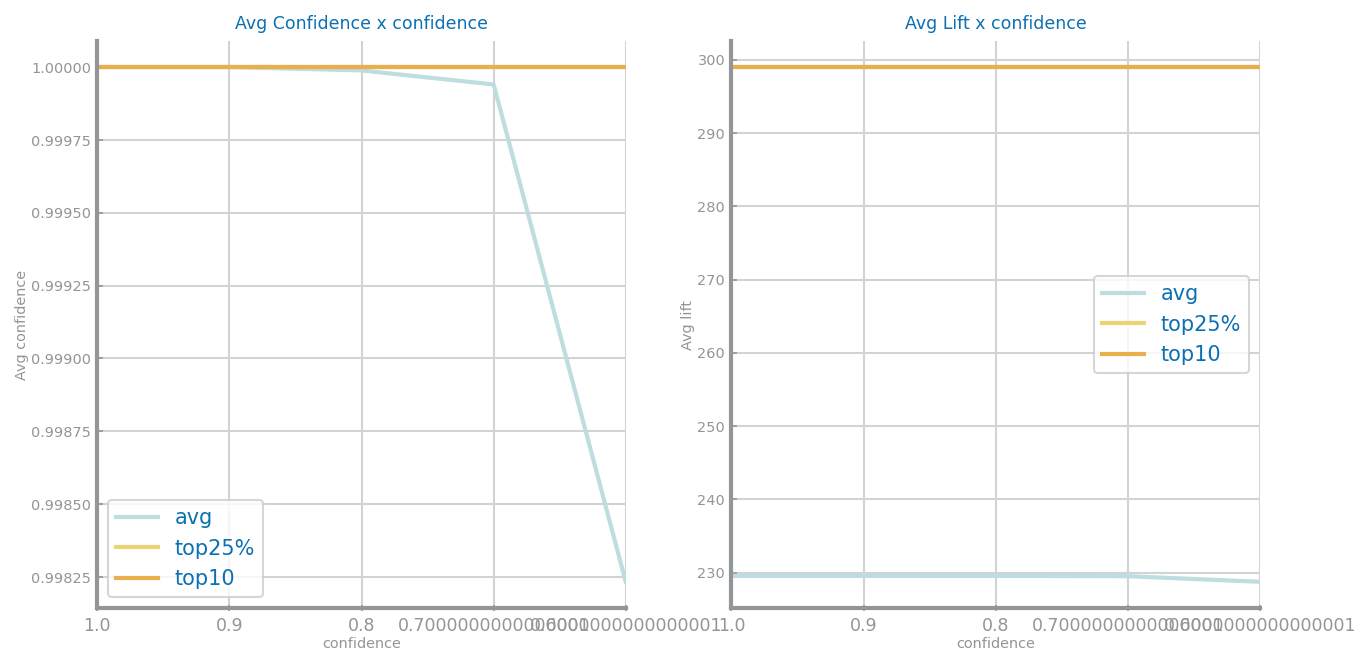

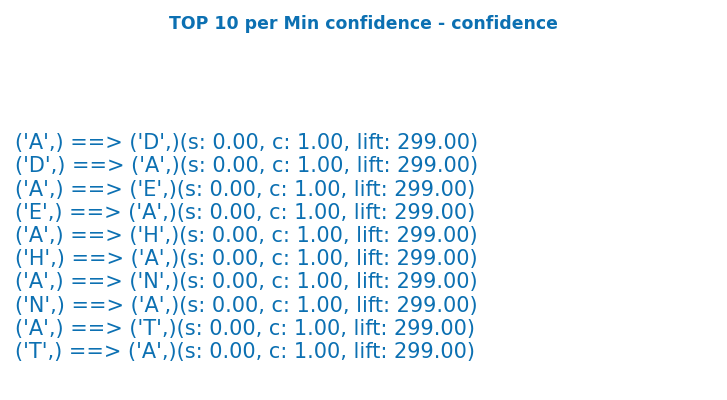

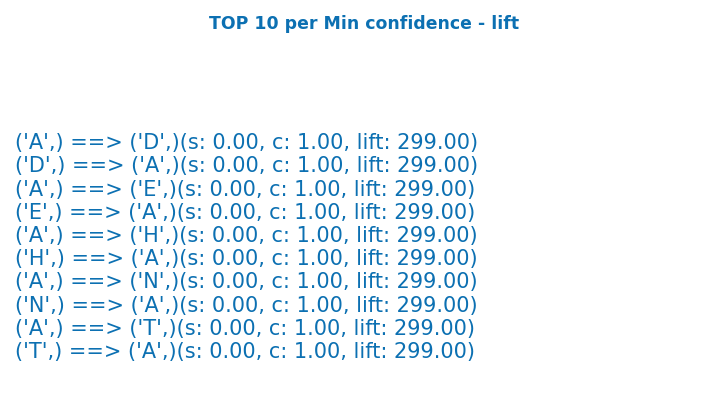

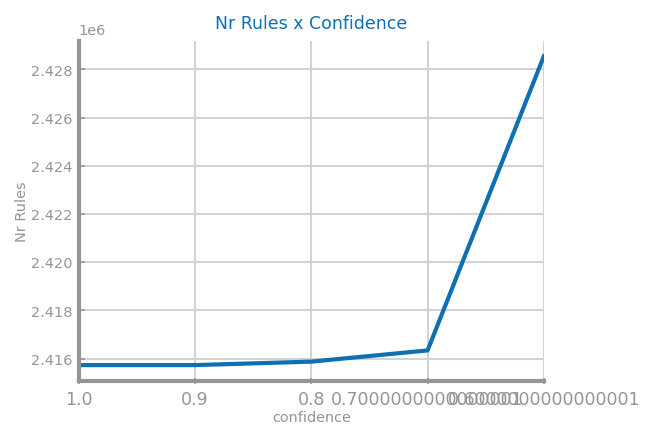

In [37]:
var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
nr_rules_cf = analyse_per_metric(rules, 'confidence', var_min_conf)
ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x Confidence', xlabel='confidence', ylabel='Nr Rules', percentage=False)

### Quality Evaluation per Support
_"The support measures the frequency of each set of items, as a percentage of the number of transactions. The support for a rule is just the support of all items in A and B together, which translates into the number of transactions that contain all the items, which just corresponds to the intersection between the set of transactions supporting A with the set of transactions
supporting B. And so, the support of the rule is then the probability of the intersection of the set of transactions supporting A and the set of transactions supporting B."_

In [38]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='support', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 0 rules


In [39]:
#var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
#nr_rules_cf = analyse_per_metric(rules, 'support', var_min_conf)
#ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x Support', xlabel='support', ylabel='Nr Rules', percentage=False)

### Quality Evaluation per Lift
_"The lift metric is commonly used to measure how much more often the antecedent and consequent of a rule A->C occur together than we would expect if they were statistically independent. If A and C are independent, the Lift score will be exactly 1"_

In [40]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='lift', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 3479156 rules


Analyse per lift...


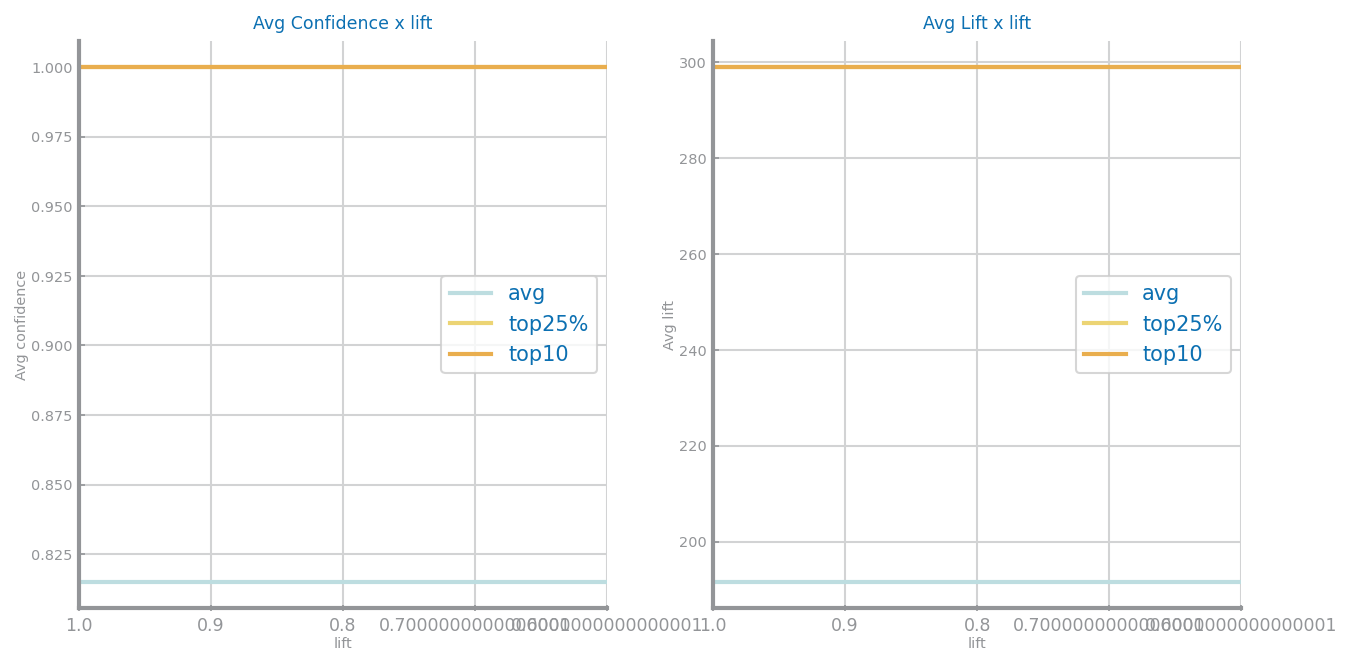

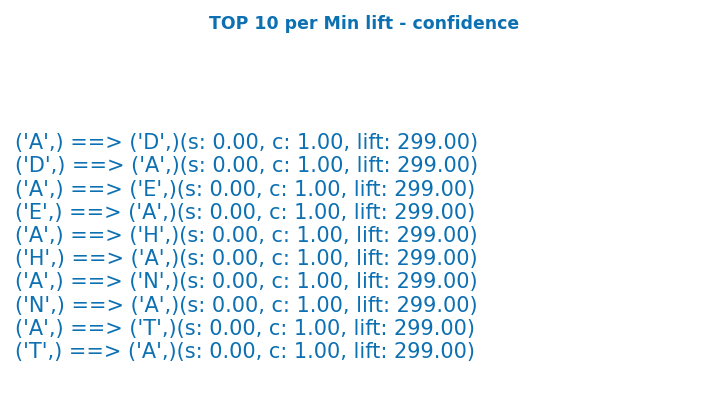

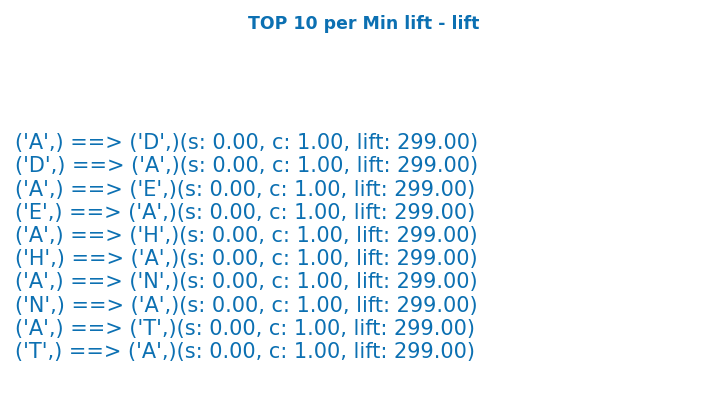

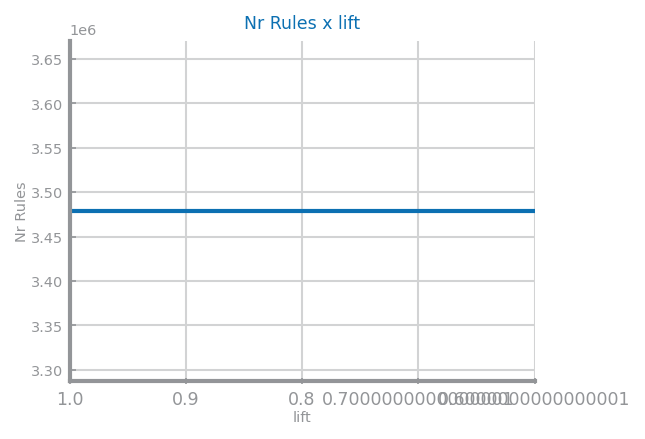

In [41]:
var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
nr_rules_cf = analyse_per_metric(rules, 'lift', var_min_conf)
ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x lift', xlabel='lift', ylabel='Nr Rules', percentage=False)

### Quality Evaluation per Leverage
_"Leverage computes the difference between the observed frequency of A and C appearing together and the frequency that would be expected if A and C were independent. A leverage value of 0 indicates independence."_

In [42]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='leverage', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 0 rules


In [43]:
#var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
#nr_rules_cf = analyse_per_metric(rules, 'leverage', var_min_conf)
#ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x leverage', xlabel='leverage', ylabel='Nr Rules', percentage=False)

### Quality Evaluation per Conviction
_"A high conviction value means that the consequent is highly depending on the antecedent. For instance, in the case of a perfect confidence score, the denominator becomes 0 (due to 1 - 1) for which the conviction score is defined as 'inf'. Similar to lift, if items are independent, the conviction is 1."_

In [44]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='conviction', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 3479156 rules


Analyse per conviction...


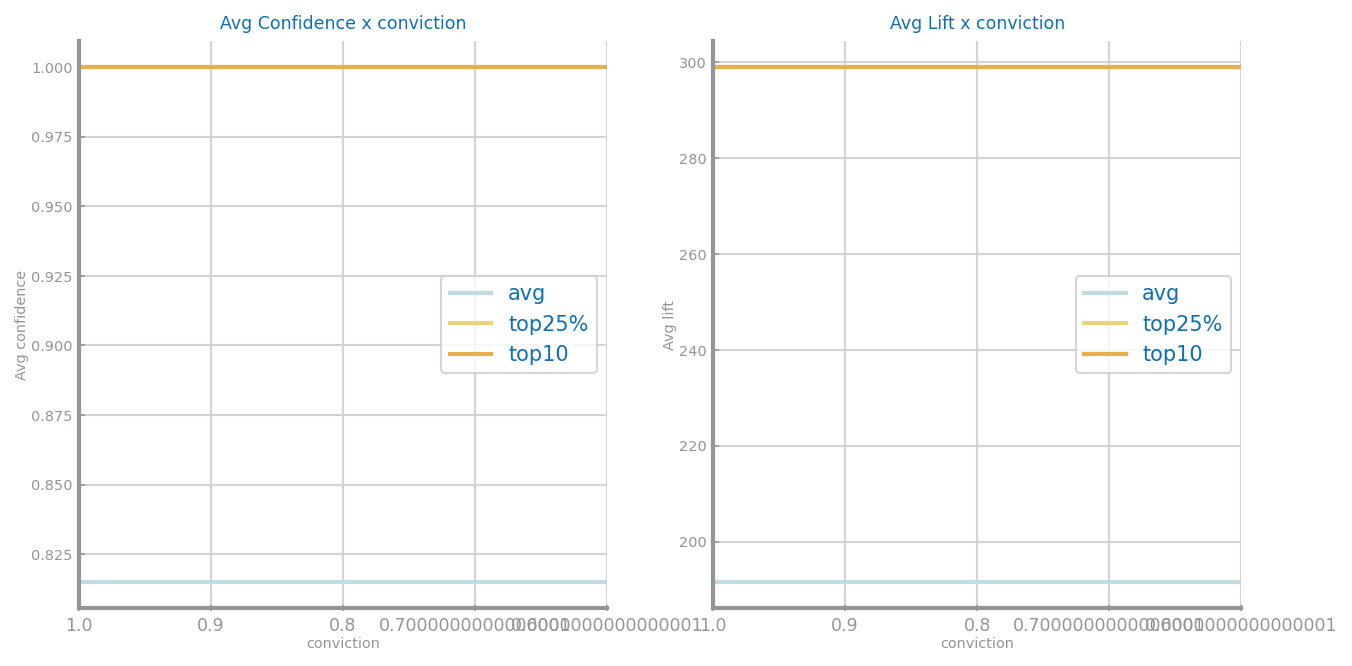

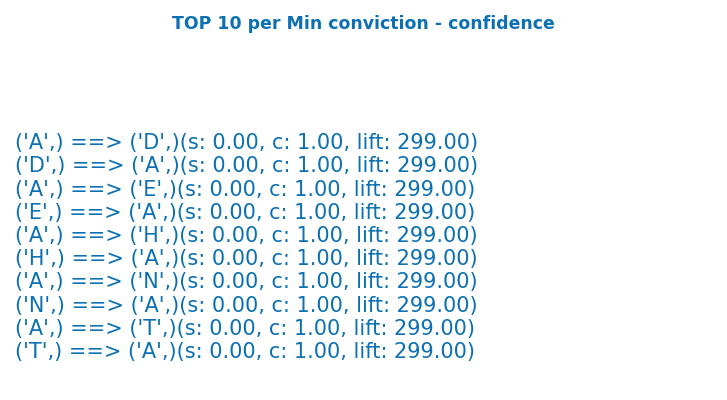

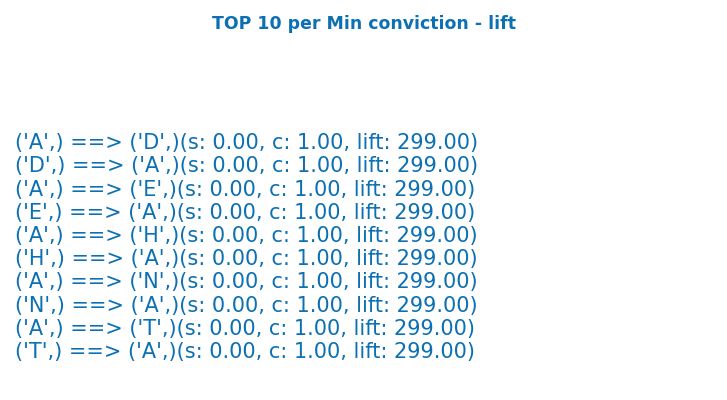

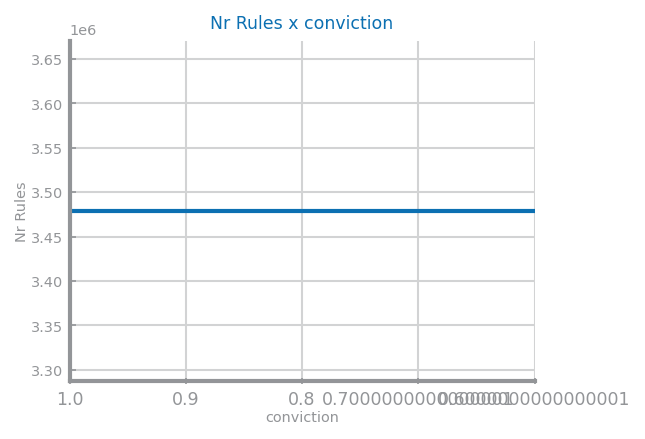

In [45]:
var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
nr_rules_cf = analyse_per_metric(rules, 'conviction', var_min_conf)
ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x conviction', xlabel='conviction', ylabel='Nr Rules', percentage=False)

<br/>
<br/>

### Discretize Numeric Variables - Number of bins = Number of Unique values for Variable

In [2]:
data: pd.DataFrame = pd.read_csv('../datasets/heart_failure_clinical_records_dataset.csv')

numeric_vars = data.select_dtypes(include='number').columns

for n in range(len(numeric_vars)):
    num_unique = len(list(set(data[numeric_vars[n]].values)))

    data[numeric_vars[n]] = pd.cut(data[numeric_vars[n]], num_unique, labels = list(range(0, num_unique)))

data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,29,0,14,0,1,1,51,6,13,1,0,0,1
1,12,0,207,0,6,0,50,2,17,1,0,1,1
2,21,0,3,0,1,0,29,3,12,1,1,1,1
3,8,1,2,0,1,0,39,6,18,1,0,1,1
4,21,1,3,1,1,0,64,9,2,0,0,2,1


### Patterns

Processing 14 combinations | Sampling itemset size 14320
19791 patterns


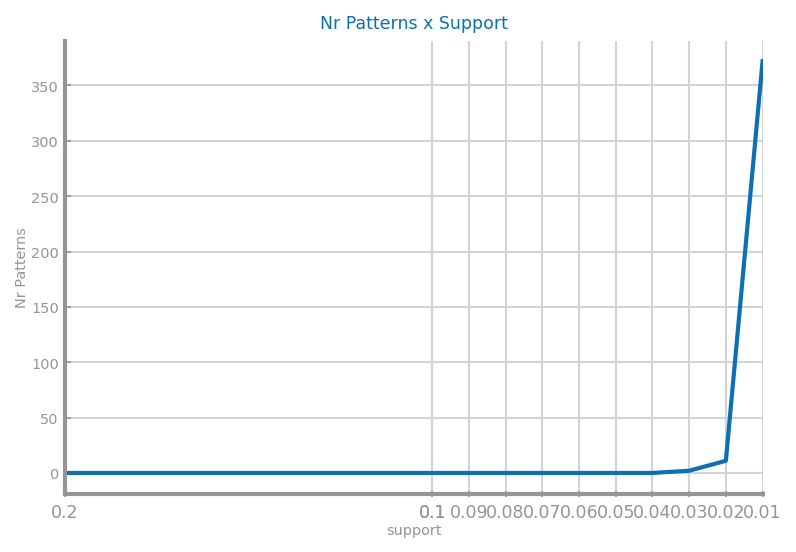

In [3]:
MIN_SUP: float = 0.001
var_min_sup =[0.2, 0.1] + [i*MIN_SUP for i  in range(100, 0, -10)]


te = TransactionEncoder()
te_ary = te.fit(data).transform(data)
data = pd.DataFrame(te_ary, columns=te.columns_)

patterns: pd.DataFrame = pm.apriori(data, min_support=MIN_SUP, use_colnames=True, verbose=True)
print(len(patterns),'patterns')
nr_patterns = []
for sup in var_min_sup:
    pat = patterns[patterns['support']>=sup]
    nr_patterns.append(len(pat))

plt.figure(figsize=(6, 4))
ds.plot_line(var_min_sup, nr_patterns, title='Nr Patterns x Support', xlabel='support', ylabel='Nr Patterns')
plt.show()

### Association Rules

In [4]:
def plot_top_rules(rules: pd.DataFrame, metric: str, per_metric: str) -> None:
    _, ax = plt.subplots(figsize=(6, 3))
    ax.grid(False)
    ax.set_axis_off()
    ax.set_title(f'TOP 10 per Min {per_metric} - {metric}', fontweight="bold")
    text = ''
    cols = ['antecedents', 'consequents']
    rules[cols] = rules[cols].applymap(lambda x: tuple(x))
    for i in range(len(rules)):
        rule = rules.iloc[i]
        text += f"{rule['antecedents']} ==> {rule['consequents']}"
        text += f"(s: {rule['support']:.2f}, c: {rule['confidence']:.2f}, lift: {rule['lift']:.2f})\n"
    ax.text(0, 0, text)
    plt.show()

def analyse_per_metric(rules: pd.DataFrame, metric: str, metric_values: list) -> list:
    print(f'Analyse per {metric}...')
    conf = {'avg': [], 'top25%': [], 'top10': []}
    lift = {'avg': [], 'top25%': [], 'top10': []}
    top_conf = []
    top_lift = []
    nr_rules = []
    for m in metric_values:
        rs = rules[rules[metric] >= m]
        nr_rules.append(len(rs))
        conf['avg'].append(rs['confidence'].mean(axis=0))
        lift['avg'].append(rs['lift'].mean(axis=0))

        top_conf = rs.nlargest(int(0.25*len(rs)), 'confidence')
        conf['top25%'].append(top_conf['confidence'].mean(axis=0))
        top_lift = rs.nlargest(int(0.25*len(rs)), 'lift')
        lift['top25%'].append(top_lift['lift'].mean(axis=0))

        top_conf = rs.nlargest(10, 'confidence')
        conf['top10'].append(top_conf['confidence'].mean(axis=0))
        top_lift = rs.nlargest(10, 'lift')
        lift['top10'].append(top_lift['lift'].mean(axis=0))

    _, axs = plt.subplots(1, 2, figsize=(10, 5), squeeze=False)
    ds.multiple_line_chart(metric_values, conf, ax=axs[0, 0], title=f'Avg Confidence x {metric}',
                           xlabel=metric, ylabel='Avg confidence')
    ds.multiple_line_chart(metric_values, lift, ax=axs[0, 1], title=f'Avg Lift x {metric}',
                           xlabel=metric, ylabel='Avg lift')
    plt.show()

    plot_top_rules(top_conf, 'confidence', metric)
    plot_top_rules(top_lift, 'lift', metric)

    return nr_rules

### Quality Evaluation per Confidence
_"The confidence of a rule A->C is the probability of seeing the consequent in a transaction given that it also contains the antecedent."_

In [5]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='confidence', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 2976813 rules


Analyse per confidence...


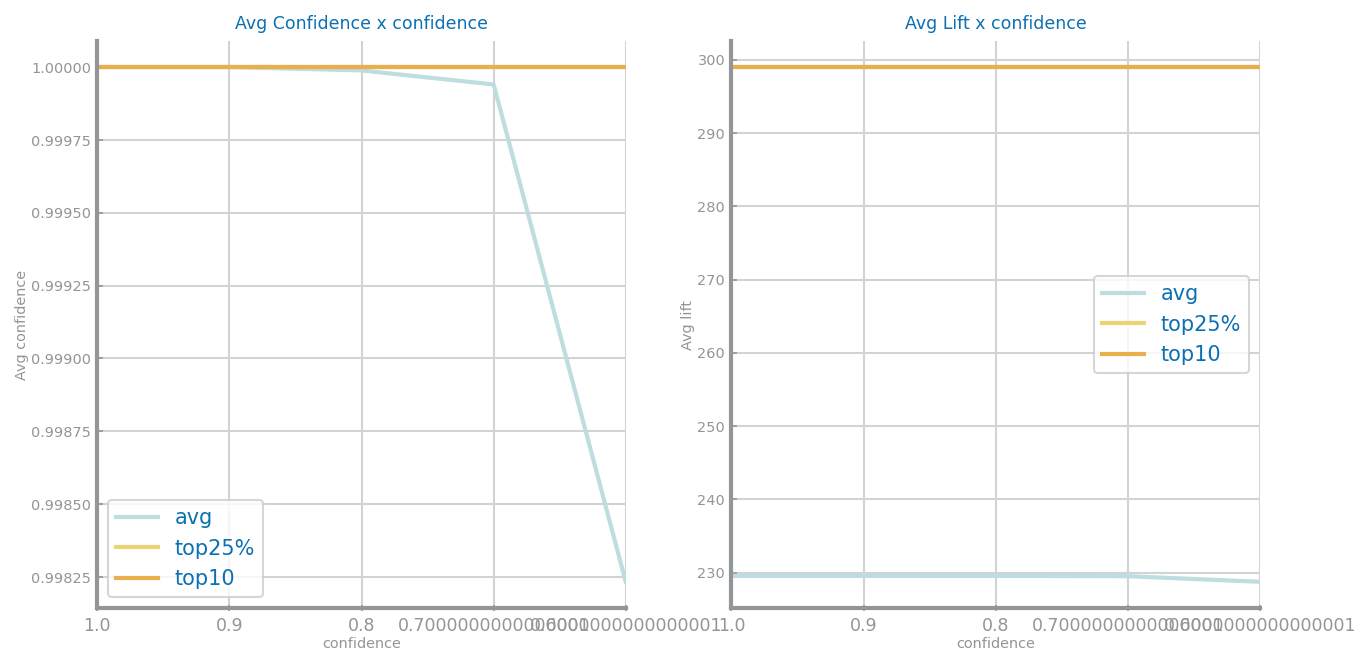

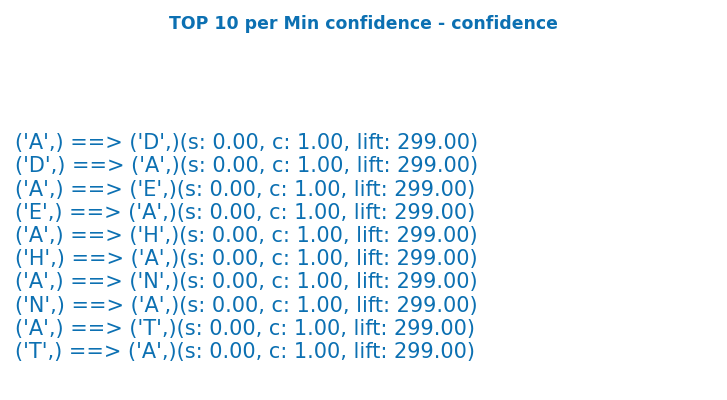

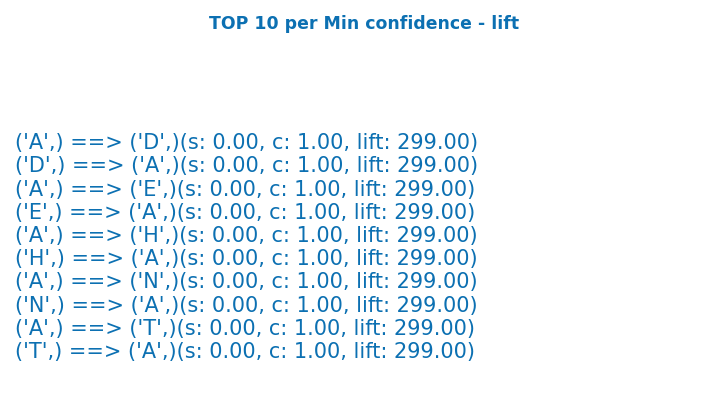

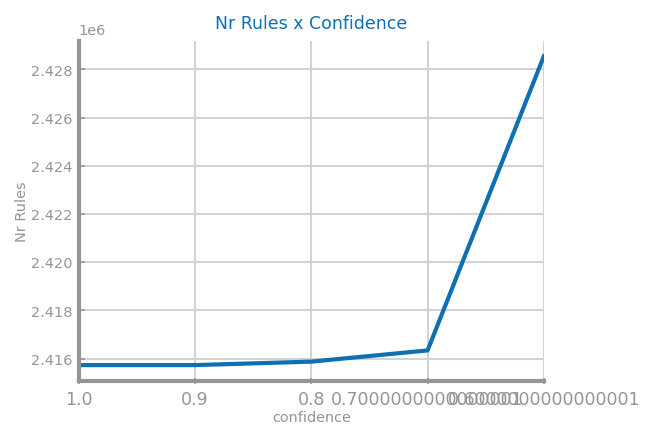

In [6]:
var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
nr_rules_cf = analyse_per_metric(rules, 'confidence', var_min_conf)
ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x Confidence', xlabel='confidence', ylabel='Nr Rules', percentage=False)

### Quality Evaluation per Support
_"The support measures the frequency of each set of items, as a percentage of the number of transactions. The support for a rule is just the support of all items in A and B together, which translates into the number of transactions that contain all the items, which just corresponds to the intersection between the set of transactions supporting A with the set of transactions
supporting B. And so, the support of the rule is then the probability of the intersection of the set of transactions supporting A and the set of transactions supporting B."_

In [7]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='support', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 0 rules


In [8]:
#var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
#nr_rules_cf = analyse_per_metric(rules, 'support', var_min_conf)
#ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x Support', xlabel='support', ylabel='Nr Rules', percentage=False)

### Quality Evaluation per Lift
_"The lift metric is commonly used to measure how much more often the antecedent and consequent of a rule A->C occur together than we would expect if they were statistically independent. If A and C are independent, the Lift score will be exactly 1"_

In [9]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='lift', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 3479156 rules


Analyse per lift...


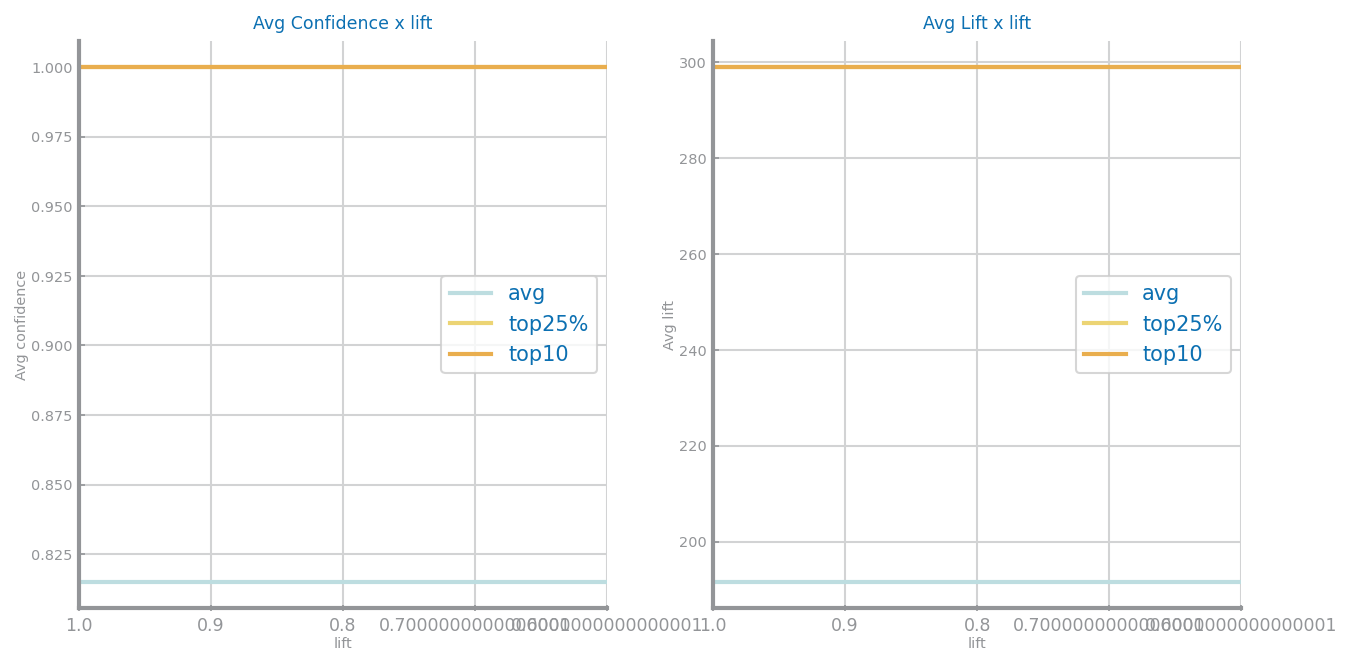

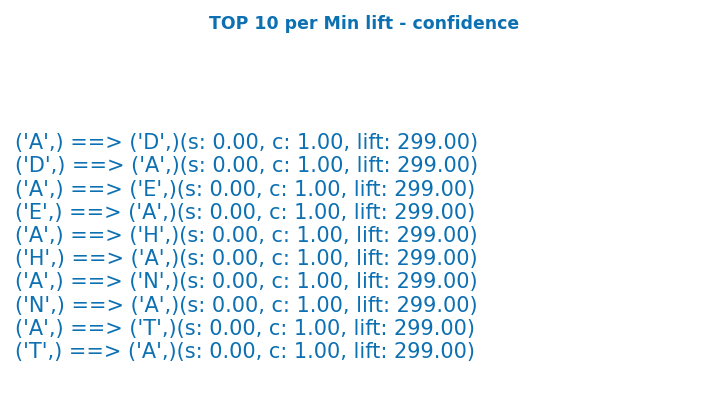

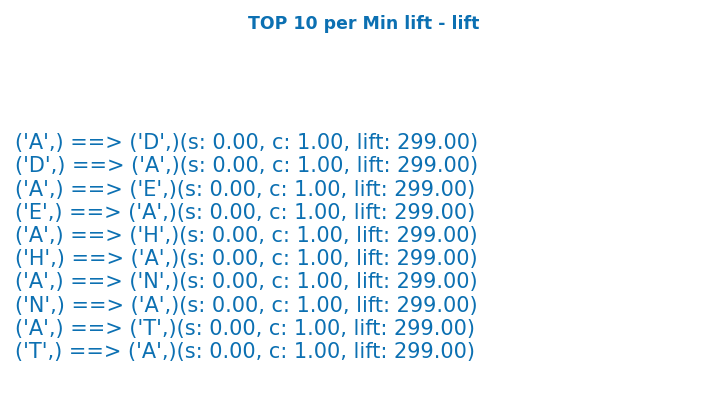

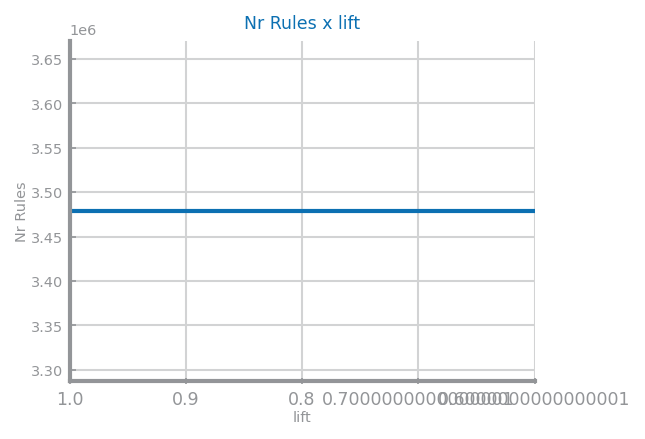

In [10]:
var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
nr_rules_cf = analyse_per_metric(rules, 'lift', var_min_conf)
ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x lift', xlabel='lift', ylabel='Nr Rules', percentage=False)

### Quality Evaluation per Leverage
_"Leverage computes the difference between the observed frequency of A and C appearing together and the frequency that would be expected if A and C were independent. A leverage value of 0 indicates independence."_

In [11]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='leverage', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 0 rules


In [12]:
#var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
#nr_rules_cf = analyse_per_metric(rules, 'leverage', var_min_conf)
#ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x leverage', xlabel='leverage', ylabel='Nr Rules', percentage=False)

### Quality Evaluation per Conviction
_"A high conviction value means that the consequent is highly depending on the antecedent. For instance, in the case of a perfect confidence score, the denominator becomes 0 (due to 1 - 1) for which the conviction score is defined as 'inf'. Similar to lift, if items are independent, the conviction is 1."_

In [13]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='conviction', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 3479156 rules


Analyse per conviction...


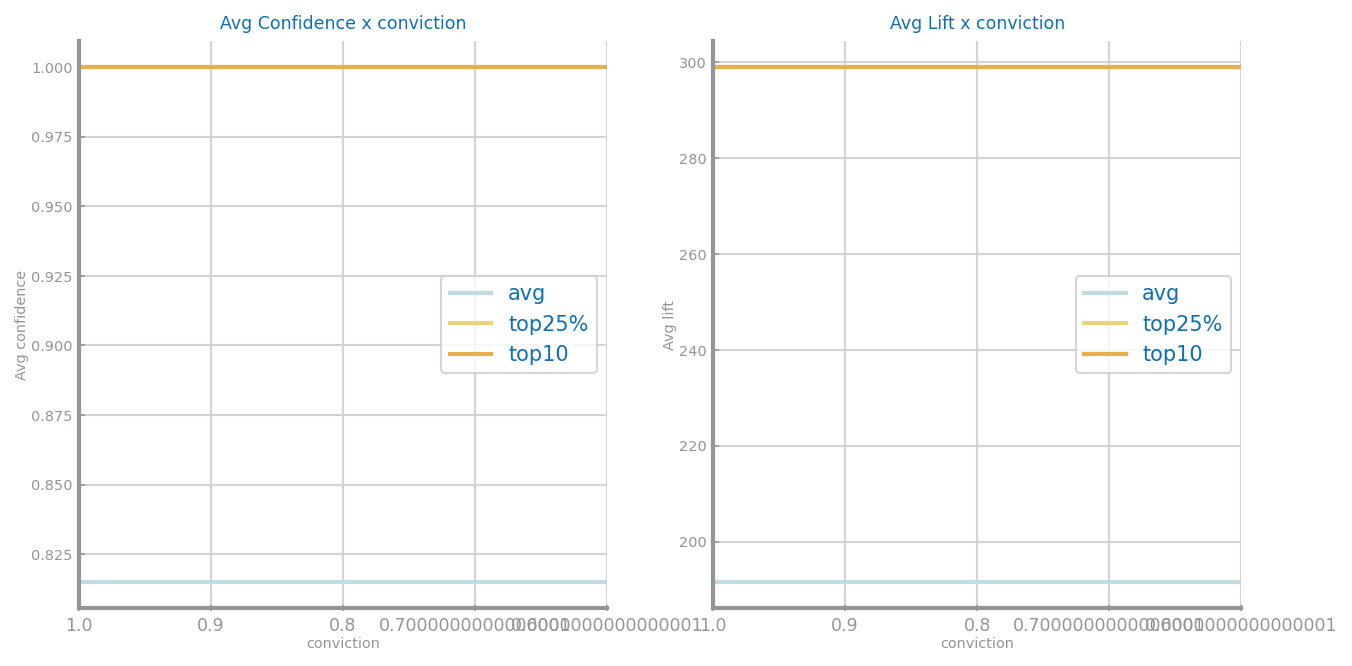

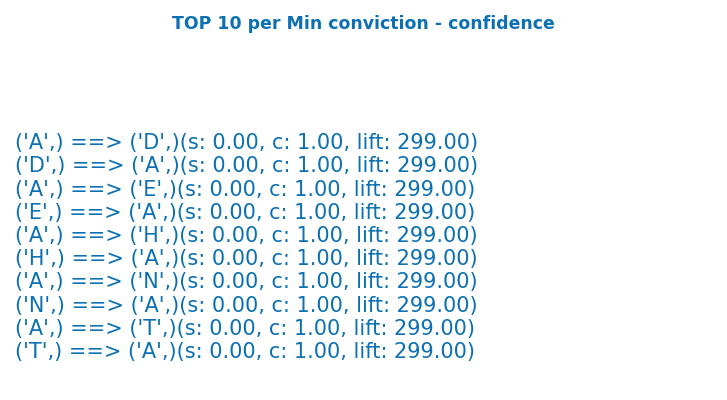

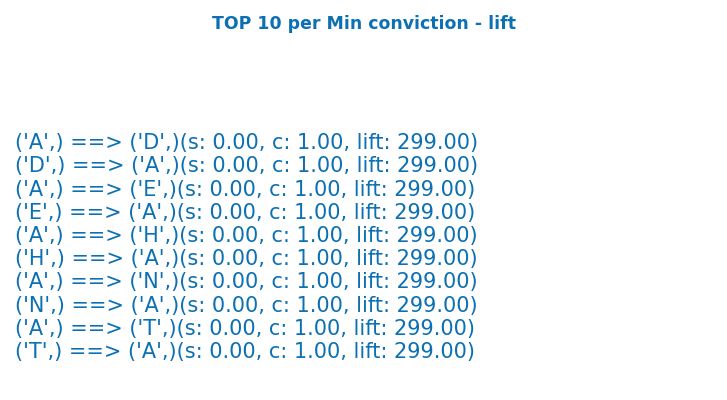

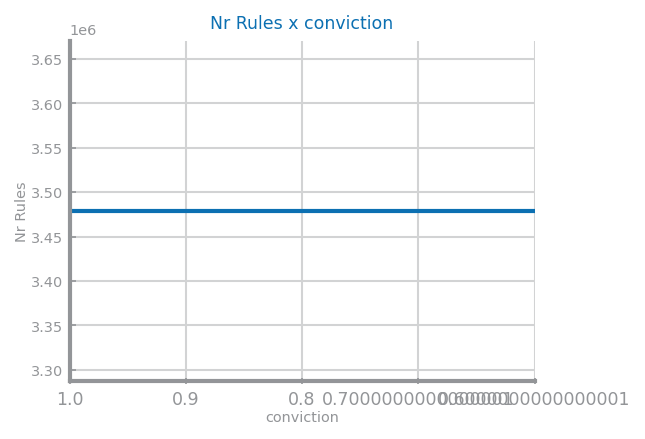

In [14]:
var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
nr_rules_cf = analyse_per_metric(rules, 'conviction', var_min_conf)
ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x conviction', xlabel='conviction', ylabel='Nr Rules', percentage=False)

<br/>
<br/>

### Summary

* How does the number of patterns discovered change with the support threshold?
    * The discovered number of patterns seems to increase exponentially in function of the given support threshold for both discretization methods.

* How does the number of rules discovered change with the confidence threshold?
    * Similarly to patterns, the number of discovered rules increases exponentially in function of the given confidence threshold for both discretization methods.
    
* How do rules quality change with the support threshold?

* How does the mean quality of rules relate to the mean quality of the top best rules?
    * Considering Confidence as the quality measure, average quality seems to be very similar to the best rules', but as the Confidence threshold increases, the average confidence drops immensely.

* What information were you able to discover?
    * Most rules are symmetric, in the sense that if A implies B, then B most likely implies A for every A, B class in the dataset.

<br/>
<br/>
<br/>
<br/>
<br/>

## QSAR Oral Toxicity

### Imports

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
import mlxtend.frequent_patterns as pm
from mlxtend.preprocessing import TransactionEncoder

### Load Data

In [48]:
data: pd.DataFrame = pd.read_csv('../datasets/qsar_oral_toxicity.csv', sep=';', header=None)   

data.columns = [str(i) for i in range(0, 1025)]

data.head()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,negative
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,negative
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative


### Patterns

Processing 360 combinations | Sampling itemset size 3
56 patterns


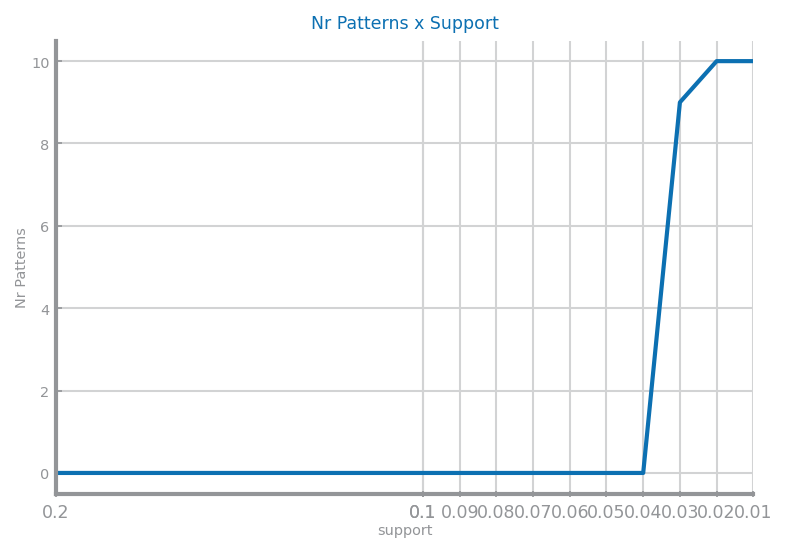

In [49]:
MIN_SUP: float = 0.001
var_min_sup =[0.2, 0.1] + [i*MIN_SUP for i  in range(100, 0, -10)]

te = TransactionEncoder()
te_ary = te.fit(data).transform(data)
data = pd.DataFrame(te_ary, columns=te.columns_)

patterns: pd.DataFrame = pm.apriori(data, min_support=MIN_SUP, use_colnames=True, verbose=True)
print(len(patterns),'patterns')
nr_patterns = []
for sup in var_min_sup:
    pat = patterns[patterns['support']>=sup]
    nr_patterns.append(len(pat))

plt.figure(figsize=(6, 4))
ds.plot_line(var_min_sup, nr_patterns, title='Nr Patterns x Support', xlabel='support', ylabel='Nr Patterns')
plt.show()

### Association Rules

In [50]:
def plot_top_rules(rules: pd.DataFrame, metric: str, per_metric: str) -> None:
    _, ax = plt.subplots(figsize=(6, 3))
    ax.grid(False)
    ax.set_axis_off()
    ax.set_title(f'TOP 10 per Min {per_metric} - {metric}', fontweight="bold")
    text = ''
    cols = ['antecedents', 'consequents']
    rules[cols] = rules[cols].applymap(lambda x: tuple(x))
    for i in range(len(rules)):
        rule = rules.iloc[i]
        text += f"{rule['antecedents']} ==> {rule['consequents']}"
        text += f"(s: {rule['support']:.2f}, c: {rule['confidence']:.2f}, lift: {rule['lift']:.2f})\n"
    ax.text(0, 0, text)
    plt.show()

def analyse_per_metric(rules: pd.DataFrame, metric: str, metric_values: list) -> list:
    print(f'Analyse per {metric}...')
    conf = {'avg': [], 'top25%': [], 'top10': []}
    lift = {'avg': [], 'top25%': [], 'top10': []}
    top_conf = []
    top_lift = []
    nr_rules = []
    for m in metric_values:
        rs = rules[rules[metric] >= m]
        nr_rules.append(len(rs))
        conf['avg'].append(rs['confidence'].mean(axis=0))
        lift['avg'].append(rs['lift'].mean(axis=0))

        top_conf = rs.nlargest(int(0.25*len(rs)), 'confidence')
        conf['top25%'].append(top_conf['confidence'].mean(axis=0))
        top_lift = rs.nlargest(int(0.25*len(rs)), 'lift')
        lift['top25%'].append(top_lift['lift'].mean(axis=0))

        top_conf = rs.nlargest(10, 'confidence')
        conf['top10'].append(top_conf['confidence'].mean(axis=0))
        top_lift = rs.nlargest(10, 'lift')
        lift['top10'].append(top_lift['lift'].mean(axis=0))

    _, axs = plt.subplots(1, 2, figsize=(10, 5), squeeze=False)
    ds.multiple_line_chart(metric_values, conf, ax=axs[0, 0], title=f'Avg Confidence x {metric}',
                           xlabel=metric, ylabel='Avg confidence')
    ds.multiple_line_chart(metric_values, lift, ax=axs[0, 1], title=f'Avg Lift x {metric}',
                           xlabel=metric, ylabel='Avg lift')
    plt.show()

    plot_top_rules(top_conf, 'confidence', metric)
    plot_top_rules(top_lift, 'lift', metric)

    return nr_rules

### Quality Evaluation per Confidence

In [51]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='confidence', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 0 rules


In [52]:
#var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
#nr_rules_cf = analyse_per_metric(rules, 'confidence', var_min_conf)
#ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x Confidence', xlabel='confidence', ylabel='Nr Rules', percentage=False)

### Quality Evaluation per Support

In [53]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='support', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 0 rules


In [54]:
#nr_rules_sp = analyse_per_metric(rules, 'support', var_min_sup)
#ds.plot_line(var_min_sup, nr_rules_sp, title='Nr rules x Support', xlabel='support', ylabel='Nr. rules', percentage=False)

### Quality Evaluation per Lift

In [55]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='lift', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 96 rules


Analyse per lift...


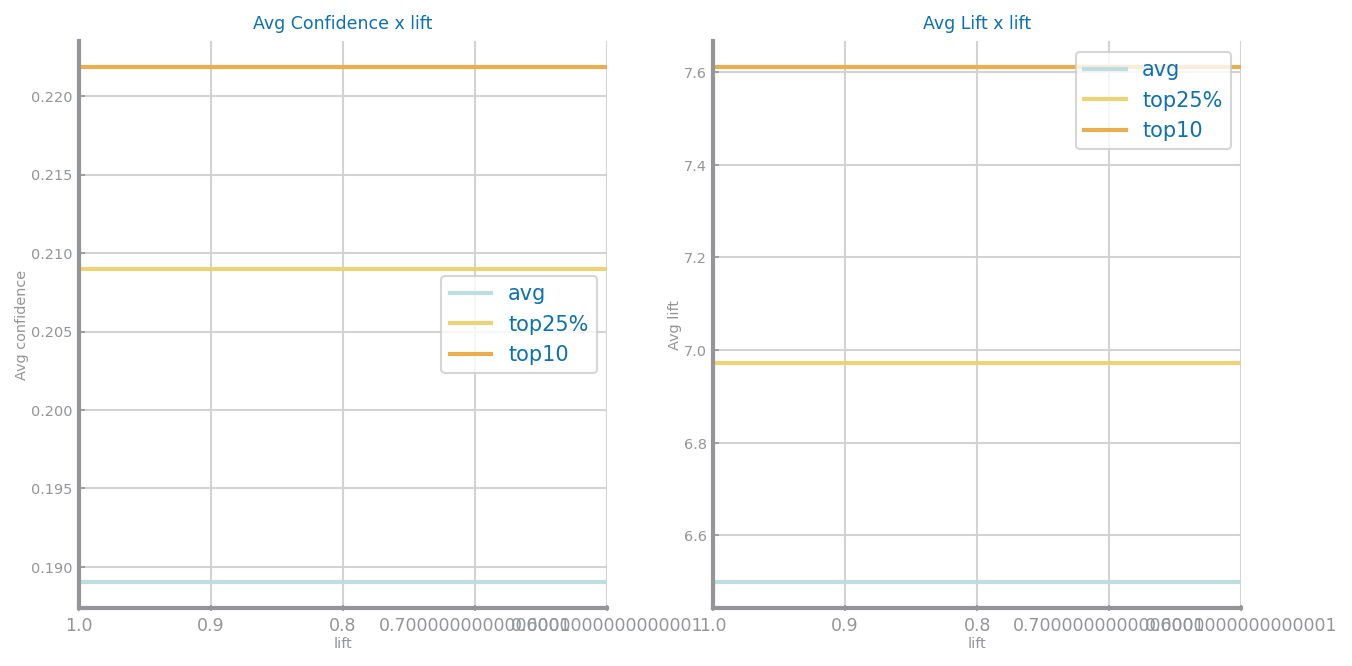

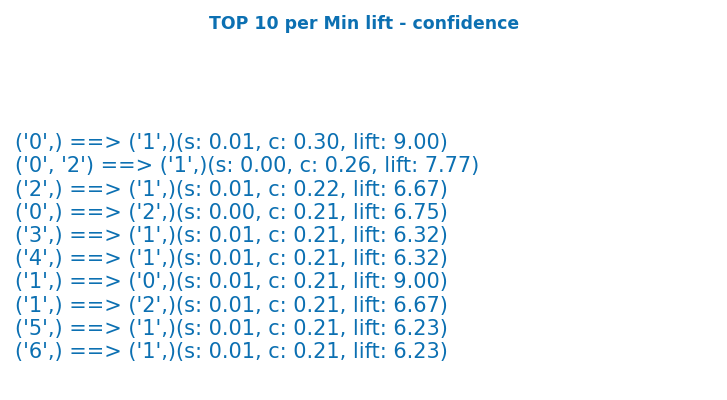

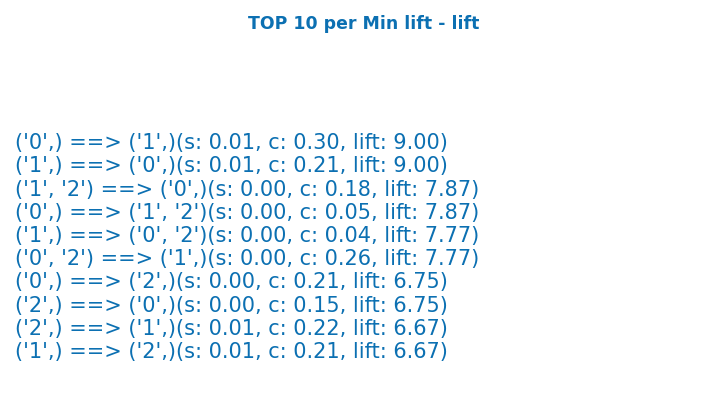

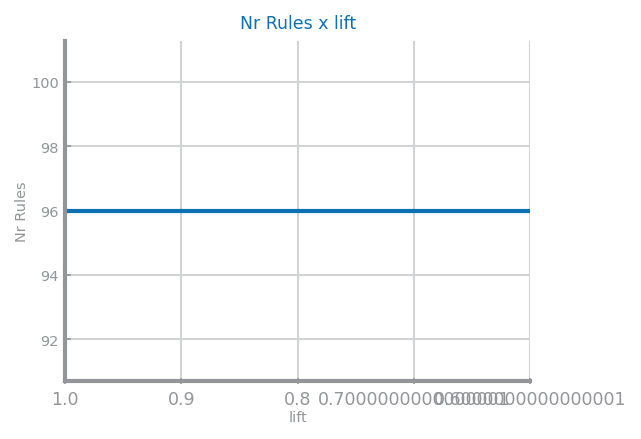

In [56]:
var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
nr_rules_cf = analyse_per_metric(rules, 'lift', var_min_conf)
ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x lift', xlabel='lift', ylabel='Nr Rules', percentage=False)

### Quality Evaluation per Leverage

In [57]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='leverage', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 0 rules


In [58]:
#var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
#nr_rules_cf = analyse_per_metric(rules, 'lift', var_min_conf)
#ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x lift', xlabel='lift', ylabel='Nr Rules', percentage=False)

### Quality Evaluation per Conviction

In [59]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='conviction', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 96 rules


Analyse per conviction...


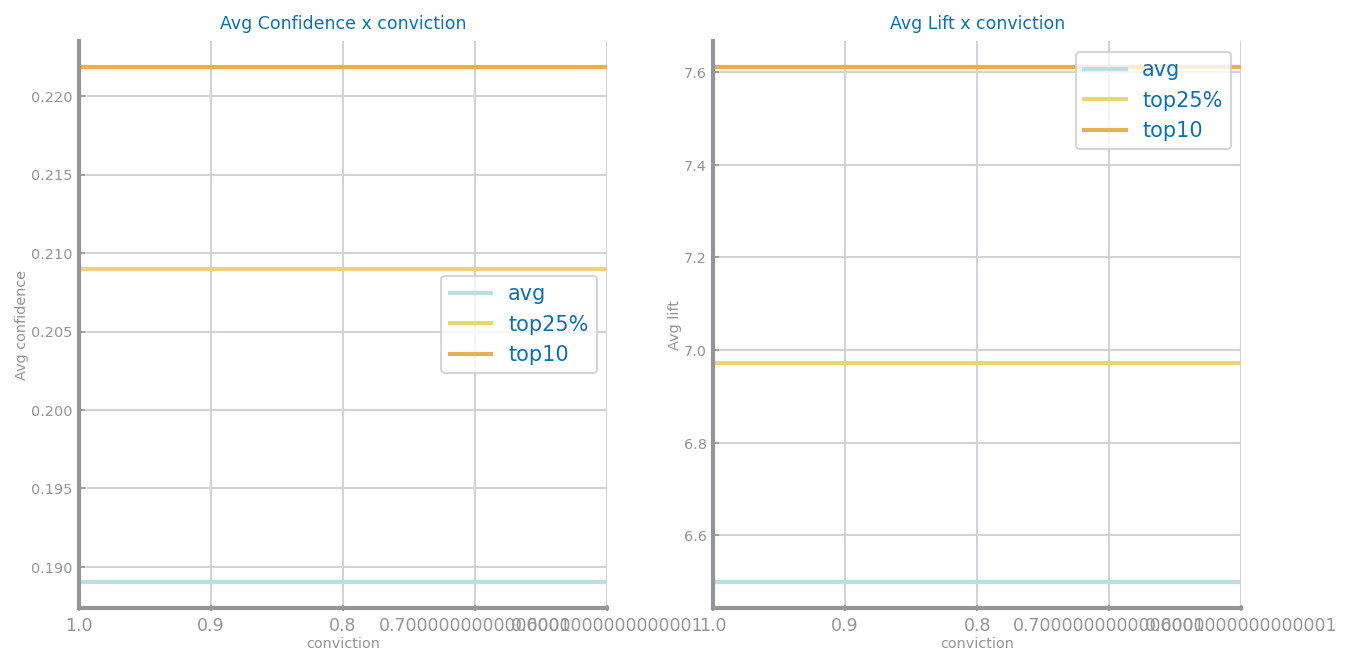

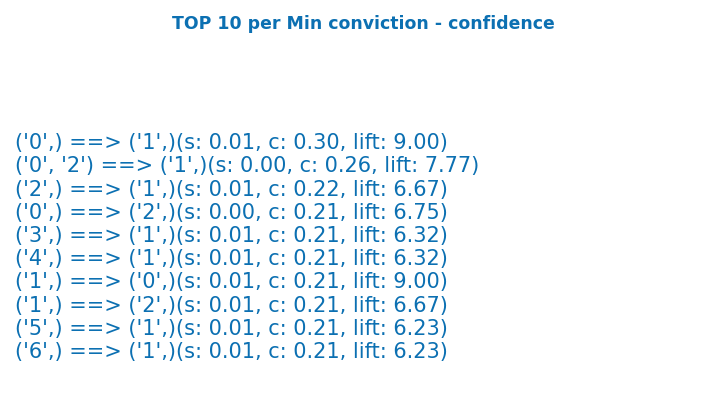

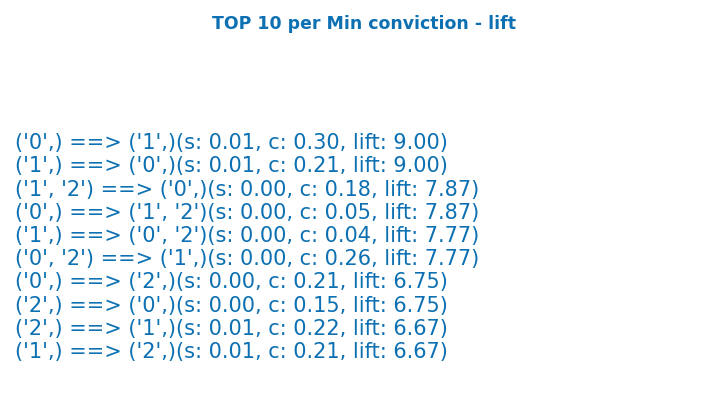

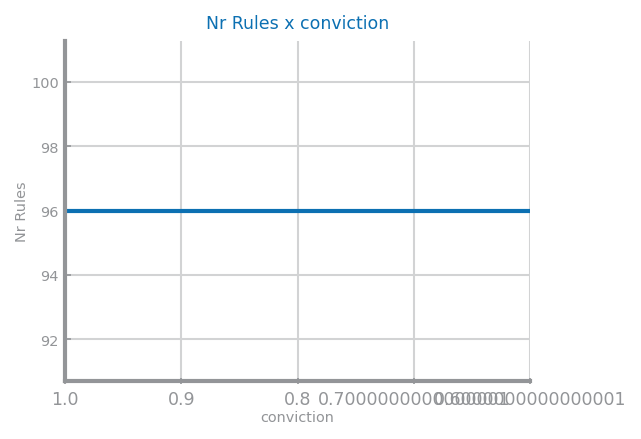

In [60]:
var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
nr_rules_cf = analyse_per_metric(rules, 'conviction', var_min_conf)
ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x conviction', xlabel='conviction', ylabel='Nr Rules', percentage=False)

### Summary

* How does the number of patterns discovered change with the support threshold?
    * The discovered number of patterns seems increase exponentially as in function of the given support threshold up to a certain point, and then the graph suggests the number of patterns stabilizes.

* How does the number of rules discovered change with the confidence threshold?

* How do rules quality change with the support threshold?

* How does the mean quality of rules relate to the mean quality of the top best rules?

* What information were you able to discover?

<br/>
<br/>
<br/>
<br/>
<br/>

## QSAR Reduced32 Oral Toxicity

### Imports

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
import mlxtend.frequent_patterns as pm
from mlxtend.preprocessing import TransactionEncoder

### Load Data

In [62]:
data: pd.DataFrame = pd.read_csv('../datasets/oral_reduced/ORAL_reduced32.csv', sep=';', header=None)   

data.columns = [str(i) for i in range(0, 33)]

data.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,00000000001000001000000000000000,00000000100000000000000000000000,00000000000000100010000000001000,00000000000000000000000000000000,00000000000000000000000000000000,00000000000000000011100001000000,00100000000000000000000000000010,01000000000000000000000000000000,00000000000100000000000000000000,10000000000000000000000000000000,...,00010000000000000000001100000000,00000000000000000010100000000000,00000000000000000000000000000000,00000000000000000000000000000000,00000001000000000000000000000000,00000000010000000000000000000000,01000000100000000000000000000000,10000000001000001000000001000100,00000000000000000000000000000000,negative
1,00100000001000001000000000000000,00000000000000000000000000000000,00000000000000100000000000001000,00000000000000000000000000000000,00000000000000000000000000000000,00000000000000000010100001001000,00000000000100000000000000000010,00000000000000000000000000000000,00000000000000000000000000000000,10000000000000000000000000000010,...,00000000000000000000001100000000,00000000000000000010100000000000,00000000000000000000000000000000,00000000001000000000000000000000,00000001000000000100000000000000,00000010011000000000000000000000,01000000100000000000000000000000,10010000001000001000000001000000,00010000000000010000000000000000,negative
2,00000000001000001000000000000000,00000000000100000000000000000000,00000000000000100000000000001000,00000000000000000000000000000000,00000000000000000000000000000000,00000000001000000010100001000000,00000000000000000000000000000010,00000000000000000000000000000000,00000000000000000000000000000000,10000000000000000000010001000000,...,00000000000000000000001100000000,00000000000000000000100000000000,00000000000000000000000000000000,00000000000000000000000000000000,00000001000000000000000000101000,00000010010000000000000001000000,01000000100000000000000000000000,10000000001100001000000001000000,00110000000000000000000001000000,negative
3,00000001001000001000000000000000,00000000000000000000000000000000,00000000000000100000000000001010,00000000000000000000000000000000,00010000000000000000000000000000,00000000000000000010100001000000,00000000000000000000000000000010,00000000000000000000000001000000,00000000000000000000000000000000,10000000000000000000000000000000,...,00000000000000000000001100000000,00000000000000000000100000000000,00000000000000000000000000000000,00000000000000000000000000000000,00000001010000000000010000000000,00000010010000000000000000000000,01001000100000000000000000000000,10000000001000001000000001000000,00010000000000001000000000000000,negative
4,00000000000001001000000000000000,00000000100000000000000000010000,00000000000000100000000000001000,00001000000000000000000000000000,00000000000000000000000000010000,00000000000000000000010000000000,00000000000101000000100000000010,00000000000000000000000001000000,00001000000000000000000000000000,10000000010000000000000000001000,...,01000000000000000000001100000000,00000000000000000000000000001010,00000000000001000001000000000000,00000000000000000000000000000000,00000001000000000100000000000000,00000010010000000000000000000000,00000010000000000000000000100000,10000000001000001000000001000000,00010100000000010000000000000000,negative


### Patterns

Processing 2 combinations | Sampling itemset size 2
2 patterns


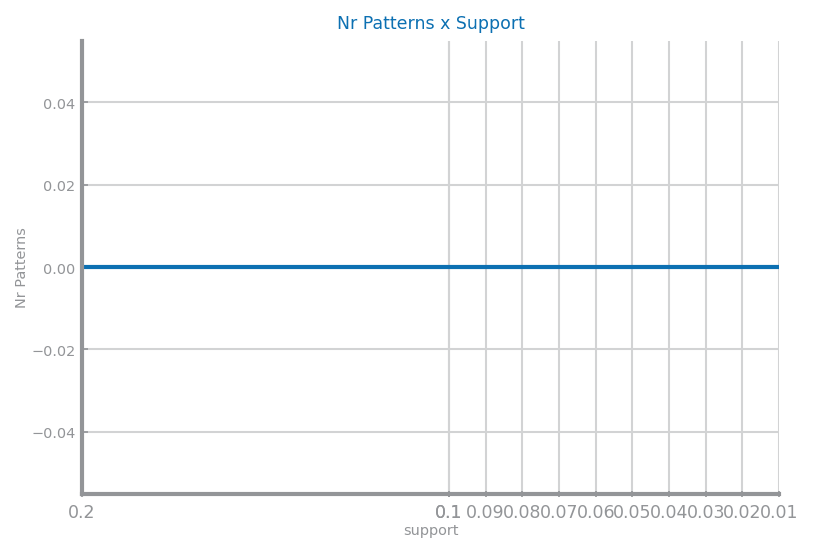

In [63]:
MIN_SUP: float = 0.001
var_min_sup =[0.2, 0.1] + [i*MIN_SUP for i  in range(100, 0, -10)]

te = TransactionEncoder()
te_ary = te.fit(data).transform(data)
data = pd.DataFrame(te_ary, columns=te.columns_)

patterns: pd.DataFrame = pm.apriori(data, min_support=MIN_SUP, use_colnames=True, verbose=True)
print(len(patterns),'patterns')
nr_patterns = []
for sup in var_min_sup:
    pat = patterns[patterns['support']>=sup]
    nr_patterns.append(len(pat))

plt.figure(figsize=(6, 4))
ds.plot_line(var_min_sup, nr_patterns, title='Nr Patterns x Support', xlabel='support', ylabel='Nr Patterns')
plt.show()

### Association Rules

In [64]:
def plot_top_rules(rules: pd.DataFrame, metric: str, per_metric: str) -> None:
    _, ax = plt.subplots(figsize=(6, 3))
    ax.grid(False)
    ax.set_axis_off()
    ax.set_title(f'TOP 10 per Min {per_metric} - {metric}', fontweight="bold")
    text = ''
    cols = ['antecedents', 'consequents']
    rules[cols] = rules[cols].applymap(lambda x: tuple(x))
    for i in range(len(rules)):
        rule = rules.iloc[i]
        text += f"{rule['antecedents']} ==> {rule['consequents']}"
        text += f"(s: {rule['support']:.2f}, c: {rule['confidence']:.2f}, lift: {rule['lift']:.2f})\n"
    ax.text(0, 0, text)
    plt.show()

def analyse_per_metric(rules: pd.DataFrame, metric: str, metric_values: list) -> list:
    print(f'Analyse per {metric}...')
    conf = {'avg': [], 'top25%': [], 'top10': []}
    lift = {'avg': [], 'top25%': [], 'top10': []}
    top_conf = []
    top_lift = []
    nr_rules = []
    for m in metric_values:
        rs = rules[rules[metric] >= m]
        nr_rules.append(len(rs))
        conf['avg'].append(rs['confidence'].mean(axis=0))
        lift['avg'].append(rs['lift'].mean(axis=0))

        top_conf = rs.nlargest(int(0.25*len(rs)), 'confidence')
        conf['top25%'].append(top_conf['confidence'].mean(axis=0))
        top_lift = rs.nlargest(int(0.25*len(rs)), 'lift')
        lift['top25%'].append(top_lift['lift'].mean(axis=0))

        top_conf = rs.nlargest(10, 'confidence')
        conf['top10'].append(top_conf['confidence'].mean(axis=0))
        top_lift = rs.nlargest(10, 'lift')
        lift['top10'].append(top_lift['lift'].mean(axis=0))

    _, axs = plt.subplots(1, 2, figsize=(10, 5), squeeze=False)
    ds.multiple_line_chart(metric_values, conf, ax=axs[0, 0], title=f'Avg Confidence x {metric}',
                           xlabel=metric, ylabel='Avg confidence')
    ds.multiple_line_chart(metric_values, lift, ax=axs[0, 1], title=f'Avg Lift x {metric}',
                           xlabel=metric, ylabel='Avg lift')
    plt.show()

    plot_top_rules(top_conf, 'confidence', metric)
    plot_top_rules(top_lift, 'lift', metric)

    return nr_rules

### Quality Evaluation per Confidence

In [65]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='confidence', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 0 rules


In [66]:
#var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
#nr_rules_cf = analyse_per_metric(rules, 'confidence', var_min_conf)
#ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x Confidence', xlabel='confidence', ylabel='Nr Rules', percentage=False)

### Quality Evaluation per Support

In [67]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='support', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 0 rules


In [68]:
#nr_rules_sp = analyse_per_metric(rules, 'support', var_min_sup)
#ds.plot_line(var_min_sup, nr_rules_sp, title='Nr rules x Support', xlabel='support', ylabel='Nr. rules', percentage=False)

### Quality Evaluation per Lift

In [69]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='lift', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 0 rules


In [70]:
#var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
#nr_rules_cf = analyse_per_metric(rules, 'lift', var_min_conf)
#ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x lift', xlabel='lift', ylabel='Nr Rules', percentage=False)

### Quality Evaluation per Leverage

In [71]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='leverage', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 0 rules


In [72]:
#var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
#nr_rules_cf = analyse_per_metric(rules, 'lift', var_min_conf)
#ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x lift', xlabel='lift', ylabel='Nr Rules', percentage=False)

### Quality Evaluation per Conviction

In [73]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='conviction', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 0 rules


In [74]:
#var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
#nr_rules_cf = analyse_per_metric(rules, 'conviction', var_min_conf)
#ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x conviction', xlabel='conviction', ylabel='Nr Rules', percentage=False)

### Summary

* How does the number of patterns discovered change with the support threshold?
    * For any given threshold, no patterns seem to be found

* How does the number of rules discovered change with the confidence threshold?

* How do rules quality change with the support threshold?

* How does the mean quality of rules relate to the mean quality of the top best rules?

* What information were you able to discover?